In [1]:
from dcmrtstruct2nii.adapters.convert.rtstructcontour2mask import DcmPatientCoords2Mask
from dcmrtstruct2nii.adapters.convert.filenameconverter import FilenameConverter
from dcmrtstruct2nii.adapters.input.contours.rtstructinputadapter import RtStructInputAdapter
from dcmrtstruct2nii.adapters.input.image.dcminputadapter import DcmInputAdapter

In [2]:
import os.path
import re

In [3]:
from dcmrtstruct2nii.adapters.output.niioutputadapter import NiiOutputAdapter
from dcmrtstruct2nii.exceptions import PathDoesNotExistException, ContourOutOfBoundsException

In [4]:
import logging
logger = logging.getLogger()

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Setup file handler
fhandler  = logging.FileHandler('my.log')
fhandler.setLevel(logging.DEBUG)
fhandler.setFormatter(formatter)

# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

# Add both handlers
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

# Show the handlers
logger.handlers



[<FileHandler C:\Users\Admin\Google Drive\projects\RTOG-0617Project\utilities\my.log (DEBUG)>,
 <StreamHandler stderr (DEBUG)>]

In [5]:
import numpy as np
from numpy import load, save
import nibabel as nib
from nilearn.image import resample_img
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import os
from os import path
from IPython.display import Markdown, display
import shutil
import mmap
import pandas as pd

In [6]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [7]:
def list_rt_structs(rtstruct_file):
    """
    Lists the structures in an DICOM RT Struct file by name.
    :param rtstruct_file: Path to the rtstruct file
    :return: A list of names, if any structures are found
    """
    if not os.path.exists(rtstruct_file):
        raise PathDoesNotExistException(f'rtstruct path does not exist: {rtstruct_file}')

    rtreader = RtStructInputAdapter()
    rtstructs = rtreader.ingest(rtstruct_file, True)
    return [struct['name'] for struct in rtstructs]

In [149]:
def dcmrtstruct2nii(rtstruct_file, patient_dicom_folder_full_path, patient_folder_name,
                    output_path, structures=None, gzip=True, 
                    mask_background_value=0, mask_foreground_value=255, convert_original_dicom=True):
    """
    Converts A DICOM and DICOM RT Struct file to nii
    :param rtstruct_file: Path to the rtstruct file
    :param patient_dicom_folder_full_path: Path to the one patient's dicom files
    :param patient_folder_name: patient's folder name used later for output file names
    :param output_path: Output path where the masks are written to
    :param structures: Optional, list of structures to convert
    :param gzip: Optional, output .nii.gz if set to True, default: True
    :raise InvalidFileFormatException: Raised when an invalid file format is given.
    :raise PathDoesNotExistException: Raised when the given path does not exist.
    :raise UnsupportedTypeException: Raised when conversion is not supported.
    :raise ValueError: Raised when mask_background_value or mask_foreground_value is invalid.
    """
    import SimpleITK as sitk
    output_path = os.path.join(output_path, '')  # make sure trailing slash is there
    if not os.path.exists(rtstruct_file):
        raise PathDoesNotExistException(f'rtstruct path does not exist: {rtstruct_file}')

    if not os.path.exists(patient_dicom_folder_full_path):
        raise PathDoesNotExistException(f'DICOM path does not exists: {patient_dicom_folder_full_path}')

    if mask_background_value < 0 or mask_background_value > 255:
        raise ValueError(f'Invalid value for mask_background_value: {mask_background_value}, must be between 0 and 255')

    if mask_foreground_value < 0 or mask_foreground_value > 255:
        raise ValueError(f'Invalid value for mask_foreground_value: {mask_foreground_value}, must be between 0 and 255')

    if structures is None:
        structures = []
    
    os.makedirs(output_path, exist_ok=True)
    logger.debug('Created output path folder %s', output_path)

    filename_converter = FilenameConverter()
    rtreader = RtStructInputAdapter()

    logger.info('Going to ingest dicom files from location %s', patient_dicom_folder_full_path)
    rtstructs = rtreader.ingest(rtstruct_file)
    dicom_images = DcmInputAdapter().ingest(patient_dicom_folder_full_path)

    dcm_patient_coords_to_mask = DcmPatientCoords2Mask()
    nii_output_adapter = NiiOutputAdapter()
    for rtstruct in rtstructs:
        if len(structures) == 0 or rtstruct['name'] in structures:
            logger.info('Working on mask {}'.format(rtstruct['name']))
            try:
                mask = dcm_patient_coords_to_mask.convert(rtstruct['sequence'], dicom_images, mask_background_value, mask_foreground_value)
            except ContourOutOfBoundsException:
                logger.warning(f'Structure {rtstruct["name"]} is out of bounds, ignoring contour!')
                continue

            mask.CopyInformation(dicom_images)
            mask_filename = patient_folder_name + '_' + filename_converter.convert(f'mask_{rtstruct["name"]}')
            logger.debug('Mask file name: %s', mask_filename)
            mask_file_output_path = os.path.join(output_path,'masks',mask_filename)
            nii_output_adapter.write(mask, f'{mask_file_output_path}', gzip)

    if convert_original_dicom:
        nii_full_path_name = os.path.join(output_path,'images', patient_folder_name + '_image')
        logger.info('Converting original DICOM to nii using full name %s', f'{nii_full_path_name}')
        nii_output_adapter.write(dicom_images, f'{nii_full_path_name}', gzip)

    logger.debug('Successfully completed getting nii images and mask for %s patient for %s RT Struct file',
                patient_folder_name, rtstruct_file)

**Set the path of folder containing input CT Data with all patients CT images as subfolder**  

In [168]:
ct_data_input_path = "F:\\RTOG0617-Images\\NSCLC-Cetuximab486\\"
output_path = "H:\\RTOG0617\\dcom2nii_numpy_output"
logger.debug("Going to use input CT Data path for all patients: %s", ct_data_input_path)

**getting paths for dicom images and rtstructure files**

In [181]:
def getpaths(srcdir):
    D = os.listdir(ct_data_input_path)
    dcmpathlst = []
    mskpathlst = []
    IDlst = []
    ptfoldername = []
    for i,ID in enumerate(D):
        D1 = os.path.join(ct_data_input_path,D[i])
        sub1 = os.listdir(D1)
        D2 = os.path.join(D1,sub1[0])
        sub2 = os.listdir(D2)
        for j,folder in enumerate(sub2):
            D3 = os.path.join(D2,sub2[j])
            sub3 = os.listdir(D3)
            if len(sub3) > 1:
                #print('This is DICOM image folder having file count of: ',len(sub3))
                path2dcm = D3 + "\\"
                #print(path2dcm)
            else:
                try:
                    rtstr = list_rt_structs(os.path.join(D3,sub3[0]))
                    if 'PTV' in rtstr:
                        #print('PTV found\n')
                        path2rtstr = os.path.join(D3,sub3[0])
                except:
                    pass
        IDlst.append(ID)
        dcmpathlst.append(path2dcm)
        mskpathlst.append(path2rtstr)
        ptfoldername.append(D1)
        #print(path2dcm)
        #print(path2rtstr)
        #print('Done for ID: ',tmpID,'\n')
    return ptfoldername,IDlst,dcmpathlst,mskpathlst

In [182]:
D,IDs,pathdcm,pathmsk = getpaths(ct_data_input_path)
print(len(D),len(IDs),len(pathdcm),len(pathmsk))

129 129 129 129


**Going to convert DICOM Images to NII image format as ZIP files along with Masks**

In [184]:
for i,ids in enumerate(IDs):
    try:
        dcmrtstruct2nii(rtstruct_file=pathmsk[i],patient_dicom_folder_full_path=pathdcm[i],
                    patient_folder_name=D[i],output_path=output_path,structures='PTV')
        out='F:\\RTOG0617-Images\\NSCLC-Cetuximab486'
        NewImageFileName=ids +'_image.nii.gz'
        NewMaskFileName=ids +'_mask_PTV.nii.gz'
        try:
            shutil.move(os.path.join(out,NewMaskFileName),os.path.join(output_path,"masks"))
            shutil.move(os.path.join(out,NewImageFileName),os.path.join(output_path,"images"))
        except FileNotFoundError as e:
            print("Mask Not Adequate for: ",ids)
    except PathDoesNotExistException as e:
        print(e)

2020-08-05 11:44:06,739 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-698987\1.3.6.1.4.1.14519.5.2.1.6329.6468.156653749165987023942579287679\1.3.6.1.4.1.14519.5.2.1.6329.6468.300850998385763117023180922270\


rtstruct path does not exist: F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-698612\1.3.6.1.4.1.14519.5.2.1.6329.6468.296100118173614137179911029728\1.3.6.1.4.1.14519.5.2.1.6329.6468.172988425907380816092229256063\000000.dcm


2020-08-05 11:44:17,647 - root - INFO - Working on mask PTV
2020-08-05 11:44:19,749 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-698987_image
2020-08-05 11:44:26,558 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-699669\1.3.6.1.4.1.14519.5.2.1.6329.6468.182461798265924485881056327348\1.3.6.1.4.1.14519.5.2.1.6329.6468.228112277600736054163546623953\
2020-08-05 11:44:35,339 - root - INFO - Working on mask PTV
2020-08-05 11:44:38,088 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-699669_image
2020-08-05 11:44:47,205 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-699697\1.3.6.1.4.1.14519.5.2.1.6329.6468.256053556472413829048441650121\1.3.6.1.4.1.14519.5.2.1.6329.6468.254434226452836922414360212075\
2020-08-05 11:44:57,678 - root - INFO - Working on mask PTV
2020

2020-08-05 11:50:20,711 - root - INFO - Working on mask PTV
2020-08-05 11:50:21,493 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-712253_image
2020-08-05 11:50:24,204 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-712281\1.3.6.1.4.1.14519.5.2.1.6329.6468.968652777685263907530695874704\1.3.6.1.4.1.14519.5.2.1.6329.6468.688591571678265106948838546706\
2020-08-05 11:50:29,035 - root - INFO - Working on mask PTV
2020-08-05 11:50:31,455 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-712281_image
2020-08-05 11:50:37,571 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-712340\1.3.6.1.4.1.14519.5.2.1.6329.6468.150081671652315747286891430706\1.3.6.1.4.1.14519.5.2.1.6329.6468.256470619128901882042822024256\
2020-08-05 11:50:44,111 - root - INFO - Working on mask PTV
2020

2020-08-05 11:55:17,509 - root - INFO - Working on mask PTV
2020-08-05 11:55:21,619 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-723321_image
2020-08-05 11:55:31,707 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-723950\1.3.6.1.4.1.14519.5.2.1.6329.6468.292551067651633674137259915751\1.3.6.1.4.1.14519.5.2.1.6329.6468.154439926210413334247424822749\
2020-08-05 11:55:43,659 - root - INFO - Working on mask PTV
2020-08-05 11:55:46,885 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-723950_image
2020-08-05 11:55:55,942 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-725662\1.3.6.1.4.1.14519.5.2.1.6329.6468.281345918811481481651475118075\1.3.6.1.4.1.14519.5.2.1.6329.6468.291708721500512176258017580366\
2020-08-05 11:56:03,021 - root - INFO - Working on mask PTV
2020

2020-08-05 12:01:56,449 - root - INFO - Working on mask PTV
2020-08-05 12:01:58,967 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-740237_image
2020-08-05 12:02:08,086 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-740377\1.3.6.1.4.1.14519.5.2.1.6329.6468.320638223989550309146440294586\1.3.6.1.4.1.14519.5.2.1.6329.6468.631423160356727189508059433035\
2020-08-05 12:02:11,218 - root - INFO - Working on mask PTV
2020-08-05 12:02:13,351 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-740377_image
2020-08-05 12:02:21,088 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-744077\1.3.6.1.4.1.14519.5.2.1.6329.6468.411902606100923697132930672379\1.3.6.1.4.1.14519.5.2.1.6329.6468.312907314322840335276700800051\
2020-08-05 12:02:27,820 - root - INFO - Working on mask PTV
2020

2020-08-05 12:06:43,964 - root - INFO - Working on mask PTV
2020-08-05 12:06:47,259 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-756630_image
2020-08-05 12:06:55,975 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-757588\1.3.6.1.4.1.14519.5.2.1.6329.6468.335668778095101382095394556646\1.3.6.1.4.1.14519.5.2.1.6329.6468.137166501835058848514575764372\
2020-08-05 12:07:01,902 - root - INFO - Working on mask PTV
2020-08-05 12:07:04,512 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-757588_image
2020-08-05 12:07:10,798 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-759543\1.3.6.1.4.1.14519.5.2.1.6329.6468.117373305220518225857689766592\1.3.6.1.4.1.14519.5.2.1.6329.6468.300962569601149729957184679012\
2020-08-05 12:07:16,910 - root - INFO - Working on mask PTV
2020

2020-08-05 12:13:02,980 - root - INFO - Working on mask PTV
2020-08-05 12:13:05,132 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-781294_image
2020-08-05 12:13:13,061 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-781895\1.3.6.1.4.1.14519.5.2.1.6329.6468.331878987297926885483913086861\1.3.6.1.4.1.14519.5.2.1.6329.6468.330655156847731040042869633217\
2020-08-05 12:13:24,778 - root - INFO - Working on mask PTV
2020-08-05 12:13:29,502 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-781895_image
2020-08-05 12:13:42,651 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-782816\1.3.6.1.4.1.14519.5.2.1.6329.6468.188759169571731367537578599730\1.3.6.1.4.1.14519.5.2.1.6329.6468.222011824811212182997425429194\
2020-08-05 12:13:50,672 - root - INFO - Working on mask PTV
2020

2020-08-05 12:19:15,163 - root - INFO - Working on mask PTV
2020-08-05 12:19:18,277 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-806570_image
2020-08-05 12:19:26,581 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-812426\1.3.6.1.4.1.14519.5.2.1.6329.6468.207247850103632457301036022923\1.3.6.1.4.1.14519.5.2.1.6329.6468.319320068987517488526853074127\
2020-08-05 12:19:37,465 - root - INFO - Working on mask PTV
2020-08-05 12:19:42,481 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-812426_image
2020-08-05 12:19:53,021 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-814060\1.3.6.1.4.1.14519.5.2.1.6329.6468.245538868482483784591919694850\1.3.6.1.4.1.14519.5.2.1.6329.6468.281084246312154739198680556300\
2020-08-05 12:20:02,006 - root - INFO - Working on mask PTV
2020

2020-08-05 12:24:33,713 - root - INFO - Working on mask PTV
2020-08-05 12:24:36,602 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-876923_image
2020-08-05 12:24:46,194 - root - INFO - Going to ingest dicom files from location F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-893415\1.3.6.1.4.1.14519.5.2.1.6329.6468.338724321366183869701408700459\1.3.6.1.4.1.14519.5.2.1.6329.6468.132398508898993927861129113111\
2020-08-05 12:24:55,744 - root - INFO - Working on mask PTV
2020-08-05 12:24:58,943 - root - INFO - Converting original DICOM to nii using full name F:\RTOG0617-Images\NSCLC-Cetuximab486\0617-893415_image


# Nifti Preprocessing and cropping

In [238]:
#Set images and mask to be predefined locatio
#Tinker doesnt works with docker as its UI and not background process
Path2ImgMsk="H:\\RTOG0617\\dcom2nii_numpy_output"
outpath="H:\\RTOG0617\\dcom2nii_numpy_output\\final_numpy_images"

In [239]:
MIN_BOUND = -1000.0
MAX_BOUND = 500.0
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [240]:
# Zero Centering
# As a final preprocessing step, it is advisory to zero center your data 
# so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels
def zero_center(image):
    image = image - image.mean()
    return image

In [241]:
# Loading nifti image and labels
#os.remove(os.path.join(output_path,".DS_Store"))
Path2Img = os.path.join(Path2ImgMsk,'images')
Path2Msk = os.path.join(Path2ImgMsk,'masks')
ImgNames = os.listdir(Path2Img)
MskNames = os.listdir(Path2Msk)
ImgNames.sort()
MskNames.sort()

In [242]:
# Check extracting Patient ID from image and mask names
print(ImgNames[0].split('_')[0])
print(MskNames[0].split('_')[0])

0617-501626
0617-501626


**Routine to Crop and process NII Images and then save it as NUMPY arrays**

In [244]:
cropped_img_list = []
ID_list = []
for i in range(0,len(ImgNames)):
    try:
        logger.info(f'Going to start cropping for {ImgNames[i]} images')
        if len(ImgNames) == len(MskNames):
            if ImgNames[i].split('_')[0] == MskNames[i].split('_')[0]:
                ID = ImgNames[i].split('_')[0]
                image_full_path = os.path.join(Path2Img,ImgNames[i])
                # Use NIB library to load zipped NII images
                # https://github.com/nipy/nibabel/blob/30c0bc561e0f34763c415a3fdc2b39cf0789a4ea/doc/source/images_and_memory.rst
                nifti_img = nib.load(image_full_path) # Loading nifti image
                nifti_img = resample_img(nifti_img, target_affine=np.eye(3), interpolation='nearest') # resampling(1,1,1)
                nifti_img_array = np.array(nifti_img.dataobj) # loaded image is converted to numpy array
                #nifti_img_array = np.rot90(nifti_img_array, k=3, axes=(0, 1)) # rotating image for proper orientation

                mask_full_path = os.path.join(Path2Msk,MskNames[i])
                nifti_msk = nib.load(mask_full_path) # Loading nifti mask
                nifti_msk = resample_img(nifti_msk, target_affine=np.eye(3), interpolation='nearest') # resamling(1,1,1)
                nifti_msk_array = np.array(nifti_msk.dataobj) # loaded mask is converted to numpy array
                #nifti_msk_array = np.rot90(nifti_msk_array, k=3, axes=(0, 1)) # rotating mask for proper orientation

                result = np.where(nifti_msk_array == 255) # Get the index of elements with value 255
                z_min,z_max = result[2].min(),result[2].max()
                z_mid = (z_max-z_min)//2 
                z_midvalue = z_min + z_mid  # this is the position of the middle most slice along z axis

                centroide = []
                x_values = []
                y_values = []
                for value in range(z_min,z_max):
                    x_val = []
                    y_val = []
                    for j,val in enumerate(result[2]):
                        if val == value:
                            x_val.append(result[1][j])
                            y_val.append(result[0][j])

                    x_midvalues = np.array(x_val)
                    y_midvalues = np.array(y_val)
                    x_values.append(x_val)
                    y_values.append(y_val)

                    centroide.append([sum(x_midvalues)//len(x_midvalues),sum(y_midvalues)//len(y_midvalues)])
                # getting cropping parameters
                cent_array = np.array(centroide) # Converting to numpy array
                mean_cent = np.around(cent_array.mean(axis=0)).astype(int) # mean
                std_cent = np.around(cent_array.std(axis=0)).astype(int) # standard deviation
                x_meanmax = mean_cent[1] + 32
                x_meanmin = mean_cent[1] - 32
                y_meanmax = mean_cent[0] + 32
                y_meanmin = mean_cent[0] - 32
                if z_midvalue < 16: # to check if no of slices with label is less than 32 if yes then set min value to zero
                    z_minval = 0
                else:
                    z_minval = z_midvalue - 32
                z_maxval = z_midvalue + 32
                cropped_img = nifti_img_array[x_meanmin:x_meanmax,y_meanmin:y_meanmax,z_minval:z_maxval]
                cropped_img = normalize(cropped_img) # image normalization (HU values converted between 0 and 1 after removing values >400)
                cropped_img = zero_center(cropped_img)
                cropped_img_list.append(cropped_img.shape)
                ID_list.append(ID)
                save(outpath + '/' + ID + '.npy',cropped_img)# Save cropped image as numpy array at selected loacation
                logger.info(f'Finished cropping for {ImgNames[i]} images')
            else:
                logger.error(f'Mask {MskNames[i]} does not matches with image {ImgNames[i]}')
        else:
            logger.error(f'Please check IMAGE folder and MASK folder. They have different length')
    except ZeroDivisionError as e:
        errorlist = []
        print('Zero Division Erros for case: ',ImgNames[i])
        errorlist.append(ImgNames[i])        
df = pd.DataFrame(cropped_img_list,columns=['X','Y','Z'])
df['CRnumber'] = ID_list
save_csv_path = os.path.join(outpath,'converted_list.csv')
df.to_csv(save_csv_path,columns=['CRnumber','X','Y','Z'])
logger.info(f'{len(ImgNames)} images are cropped. Details are saved in a file named "converted_list.csv" and path to file is:{outpath}')

2020-08-05 15:55:50,231 - root - INFO - Going to start cropping for 0617-501626_image.nii.gz images
2020-08-05 15:56:46,261 - root - INFO - Going to start cropping for 0617-503047_image.nii.gz images


Zero Division Erros for case:  0617-501626_image.nii.gz


2020-08-05 15:57:11,127 - root - INFO - Finished cropping for 0617-503047_image.nii.gz images
2020-08-05 15:57:11,129 - root - INFO - Going to start cropping for 0617-503217_image.nii.gz images
2020-08-05 15:57:36,979 - root - INFO - Finished cropping for 0617-503217_image.nii.gz images
2020-08-05 15:57:36,981 - root - INFO - Going to start cropping for 0617-503777_image.nii.gz images
2020-08-05 15:58:07,754 - root - INFO - Finished cropping for 0617-503777_image.nii.gz images
2020-08-05 15:58:07,755 - root - INFO - Going to start cropping for 0617-503844_image.nii.gz images
2020-08-05 15:59:44,965 - root - INFO - Finished cropping for 0617-503844_image.nii.gz images
2020-08-05 15:59:44,967 - root - INFO - Going to start cropping for 0617-507613_image.nii.gz images
2020-08-05 16:00:30,267 - root - INFO - Finished cropping for 0617-507613_image.nii.gz images
2020-08-05 16:00:30,268 - root - INFO - Going to start cropping for 0617-509847_image.nii.gz images
2020-08-05 16:01:57,609 - root

Zero Division Erros for case:  0617-520664_image.nii.gz


2020-08-05 16:10:52,705 - root - INFO - Finished cropping for 0617-520739_image.nii.gz images
2020-08-05 16:10:52,706 - root - INFO - Going to start cropping for 0617-521719_image.nii.gz images
2020-08-05 16:11:42,948 - root - INFO - Finished cropping for 0617-521719_image.nii.gz images
2020-08-05 16:11:42,949 - root - INFO - Going to start cropping for 0617-522632_image.nii.gz images
2020-08-05 16:12:11,495 - root - INFO - Finished cropping for 0617-522632_image.nii.gz images
2020-08-05 16:12:11,496 - root - INFO - Going to start cropping for 0617-524084_image.nii.gz images
2020-08-05 16:12:43,531 - root - INFO - Finished cropping for 0617-524084_image.nii.gz images
2020-08-05 16:12:43,533 - root - INFO - Going to start cropping for 0617-526612_image.nii.gz images
2020-08-05 16:14:02,220 - root - INFO - Going to start cropping for 0617-528984_image.nii.gz images


Zero Division Erros for case:  0617-526612_image.nii.gz


2020-08-05 16:15:32,143 - root - INFO - Finished cropping for 0617-528984_image.nii.gz images
2020-08-05 16:15:32,144 - root - INFO - Going to start cropping for 0617-529217_image.nii.gz images
2020-08-05 16:16:29,825 - root - INFO - Finished cropping for 0617-529217_image.nii.gz images
2020-08-05 16:16:29,826 - root - INFO - Going to start cropping for 0617-529851_image.nii.gz images
2020-08-05 16:17:21,390 - root - INFO - Finished cropping for 0617-529851_image.nii.gz images
2020-08-05 16:17:21,391 - root - INFO - Going to start cropping for 0617-532478_image.nii.gz images
2020-08-05 16:17:44,353 - root - INFO - Finished cropping for 0617-532478_image.nii.gz images
2020-08-05 16:17:44,354 - root - INFO - Going to start cropping for 0617-533399_image.nii.gz images
2020-08-05 16:18:48,744 - root - INFO - Finished cropping for 0617-533399_image.nii.gz images
2020-08-05 16:18:48,745 - root - INFO - Going to start cropping for 0617-535250_image.nii.gz images
2020-08-05 16:19:36,732 - root

Zero Division Erros for case:  0617-543063_image.nii.gz


2020-08-05 16:29:01,616 - root - INFO - Finished cropping for 0617-543546_image.nii.gz images
2020-08-05 16:29:01,617 - root - INFO - Going to start cropping for 0617-543978_image.nii.gz images
2020-08-05 16:29:28,459 - root - INFO - Finished cropping for 0617-543978_image.nii.gz images
2020-08-05 16:29:28,460 - root - INFO - Going to start cropping for 0617-544413_image.nii.gz images
2020-08-05 16:30:17,687 - root - INFO - Finished cropping for 0617-544413_image.nii.gz images
2020-08-05 16:30:17,688 - root - INFO - Going to start cropping for 0617-544655_image.nii.gz images
2020-08-05 16:31:04,587 - root - INFO - Finished cropping for 0617-544655_image.nii.gz images
2020-08-05 16:31:04,588 - root - INFO - Going to start cropping for 0617-544856_image.nii.gz images
2020-08-05 16:31:52,727 - root - INFO - Finished cropping for 0617-544856_image.nii.gz images
2020-08-05 16:31:52,728 - root - INFO - Going to start cropping for 0617-545827_image.nii.gz images
2020-08-05 16:32:40,836 - root

Zero Division Erros for case:  0617-547163_image.nii.gz


2020-08-05 16:35:02,917 - root - INFO - Finished cropping for 0617-547928_image.nii.gz images
2020-08-05 16:35:02,918 - root - INFO - Going to start cropping for 0617-548132_image.nii.gz images
2020-08-05 16:35:34,000 - root - INFO - Finished cropping for 0617-548132_image.nii.gz images
2020-08-05 16:35:34,001 - root - INFO - Going to start cropping for 0617-548359_image.nii.gz images
2020-08-05 16:36:10,419 - root - INFO - Finished cropping for 0617-548359_image.nii.gz images
2020-08-05 16:36:10,420 - root - INFO - Going to start cropping for 0617-548432_image.nii.gz images
2020-08-05 16:36:57,366 - root - INFO - Going to start cropping for 0617-549126_image.nii.gz images


Zero Division Erros for case:  0617-548432_image.nii.gz


2020-08-05 16:38:03,322 - root - INFO - Finished cropping for 0617-549126_image.nii.gz images
2020-08-05 16:38:03,324 - root - INFO - Going to start cropping for 0617-549568_image.nii.gz images
2020-08-05 16:38:49,917 - root - INFO - Finished cropping for 0617-549568_image.nii.gz images
2020-08-05 16:38:49,918 - root - INFO - Going to start cropping for 0617-550149_image.nii.gz images
2020-08-05 16:39:53,080 - root - INFO - Finished cropping for 0617-550149_image.nii.gz images
2020-08-05 16:39:53,081 - root - INFO - Going to start cropping for 0617-551414_image.nii.gz images
2020-08-05 16:40:28,001 - root - INFO - Finished cropping for 0617-551414_image.nii.gz images
2020-08-05 16:40:28,002 - root - INFO - Going to start cropping for 0617-553859_image.nii.gz images
2020-08-05 16:40:56,174 - root - INFO - Finished cropping for 0617-553859_image.nii.gz images
2020-08-05 16:40:56,176 - root - INFO - Going to start cropping for 0617-553904_image.nii.gz images
2020-08-05 16:41:35,148 - root

Zero Division Erros for case:  0617-576833_image.nii.gz


2020-08-05 17:12:19,866 - root - INFO - Finished cropping for 0617-577084_image.nii.gz images
2020-08-05 17:12:19,868 - root - INFO - Going to start cropping for 0617-578008_image.nii.gz images
2020-08-05 17:13:01,597 - root - INFO - Finished cropping for 0617-578008_image.nii.gz images
2020-08-05 17:13:01,598 - root - INFO - Going to start cropping for 0617-578019_image.nii.gz images
2020-08-05 17:14:05,767 - root - INFO - Finished cropping for 0617-578019_image.nii.gz images
2020-08-05 17:14:05,769 - root - INFO - Going to start cropping for 0617-578498_image.nii.gz images
2020-08-05 17:14:37,962 - root - INFO - Finished cropping for 0617-578498_image.nii.gz images
2020-08-05 17:14:37,963 - root - INFO - Going to start cropping for 0617-579384_image.nii.gz images
2020-08-05 17:15:11,814 - root - INFO - Finished cropping for 0617-579384_image.nii.gz images
2020-08-05 17:15:11,815 - root - INFO - Going to start cropping for 0617-579417_image.nii.gz images
2020-08-05 17:16:07,388 - root

Zero Division Erros for case:  0617-579944_image.nii.gz


2020-08-05 17:21:13,440 - root - INFO - Finished cropping for 0617-580557_image.nii.gz images
2020-08-05 17:21:13,441 - root - INFO - Going to start cropping for 0617-580704_image.nii.gz images
2020-08-05 17:21:46,889 - root - INFO - Finished cropping for 0617-580704_image.nii.gz images
2020-08-05 17:21:46,890 - root - INFO - Going to start cropping for 0617-581703_image.nii.gz images
2020-08-05 17:22:24,367 - root - INFO - Finished cropping for 0617-581703_image.nii.gz images
2020-08-05 17:22:24,369 - root - INFO - Going to start cropping for 0617-581896_image.nii.gz images
2020-08-05 17:23:12,310 - root - INFO - Finished cropping for 0617-581896_image.nii.gz images
2020-08-05 17:23:12,311 - root - INFO - Going to start cropping for 0617-582528_image.nii.gz images
2020-08-05 17:24:56,888 - root - INFO - Finished cropping for 0617-582528_image.nii.gz images
2020-08-05 17:24:56,890 - root - INFO - Going to start cropping for 0617-583960_image.nii.gz images
2020-08-05 17:27:04,903 - root

2020-08-05 18:07:08,131 - root - INFO - Going to start cropping for 0617-609173_image.nii.gz images
2020-08-05 18:08:17,056 - root - INFO - Finished cropping for 0617-609173_image.nii.gz images
2020-08-05 18:08:17,057 - root - INFO - Going to start cropping for 0617-610451_image.nii.gz images
2020-08-05 18:08:52,341 - root - INFO - Finished cropping for 0617-610451_image.nii.gz images
2020-08-05 18:08:52,343 - root - INFO - Going to start cropping for 0617-610598_image.nii.gz images
2020-08-05 18:09:12,851 - root - INFO - Going to start cropping for 0617-611871_image.nii.gz images


Zero Division Erros for case:  0617-610598_image.nii.gz


2020-08-05 18:10:15,183 - root - INFO - Finished cropping for 0617-611871_image.nii.gz images
2020-08-05 18:10:15,184 - root - INFO - Going to start cropping for 0617-612136_image.nii.gz images
2020-08-05 18:13:12,100 - root - INFO - Finished cropping for 0617-612136_image.nii.gz images
2020-08-05 18:13:12,102 - root - INFO - Going to start cropping for 0617-612226_image.nii.gz images
2020-08-05 18:14:40,903 - root - INFO - Finished cropping for 0617-612226_image.nii.gz images
2020-08-05 18:14:40,904 - root - INFO - Going to start cropping for 0617-612700_image.nii.gz images
2020-08-05 18:15:32,024 - root - INFO - Finished cropping for 0617-612700_image.nii.gz images
2020-08-05 18:15:32,026 - root - INFO - Going to start cropping for 0617-613919_image.nii.gz images
2020-08-05 18:16:08,402 - root - INFO - Finished cropping for 0617-613919_image.nii.gz images
2020-08-05 18:16:08,403 - root - INFO - Going to start cropping for 0617-614287_image.nii.gz images
2020-08-05 18:16:46,838 - root

Zero Division Erros for case:  0617-618237_image.nii.gz


2020-08-05 18:19:56,048 - root - INFO - Finished cropping for 0617-618386_image.nii.gz images
2020-08-05 18:19:56,049 - root - INFO - Going to start cropping for 0617-618778_image.nii.gz images
2020-08-05 18:20:48,470 - root - INFO - Finished cropping for 0617-618778_image.nii.gz images
2020-08-05 18:20:48,471 - root - INFO - Going to start cropping for 0617-619079_image.nii.gz images
2020-08-05 18:22:40,386 - root - INFO - Finished cropping for 0617-619079_image.nii.gz images
2020-08-05 18:22:40,387 - root - INFO - Going to start cropping for 0617-619556_image.nii.gz images
2020-08-05 18:23:43,431 - root - INFO - Finished cropping for 0617-619556_image.nii.gz images
2020-08-05 18:23:43,432 - root - INFO - Going to start cropping for 0617-619629_image.nii.gz images
2020-08-05 18:24:39,958 - root - INFO - Finished cropping for 0617-619629_image.nii.gz images
2020-08-05 18:24:39,959 - root - INFO - Going to start cropping for 0617-619856_image.nii.gz images
2020-08-05 18:25:13,685 - root

Zero Division Erros for case:  0617-636693_image.nii.gz


2020-08-05 18:51:46,665 - root - INFO - Finished cropping for 0617-637392_image.nii.gz images
2020-08-05 18:51:46,666 - root - INFO - Going to start cropping for 0617-637689_image.nii.gz images
2020-08-05 18:53:02,524 - root - INFO - Finished cropping for 0617-637689_image.nii.gz images
2020-08-05 18:53:02,526 - root - INFO - Going to start cropping for 0617-637899_image.nii.gz images
2020-08-05 18:53:40,443 - root - INFO - Finished cropping for 0617-637899_image.nii.gz images
2020-08-05 18:53:40,444 - root - INFO - Going to start cropping for 0617-638735_image.nii.gz images
2020-08-05 18:54:20,579 - root - INFO - Finished cropping for 0617-638735_image.nii.gz images
2020-08-05 18:54:20,581 - root - INFO - Going to start cropping for 0617-639047_image.nii.gz images
2020-08-05 18:55:58,209 - root - INFO - Finished cropping for 0617-639047_image.nii.gz images
2020-08-05 18:55:58,210 - root - INFO - Going to start cropping for 0617-639115_image.nii.gz images
2020-08-05 18:58:47,120 - root

Zero Division Erros for case:  0617-644865_image.nii.gz


2020-08-05 19:08:40,125 - root - INFO - Finished cropping for 0617-645780_image.nii.gz images
2020-08-05 19:08:40,126 - root - INFO - Going to start cropping for 0617-646888_image.nii.gz images
2020-08-05 19:10:30,159 - root - INFO - Finished cropping for 0617-646888_image.nii.gz images
2020-08-05 19:10:30,160 - root - INFO - Going to start cropping for 0617-647078_image.nii.gz images
2020-08-05 19:11:33,762 - root - INFO - Finished cropping for 0617-647078_image.nii.gz images
2020-08-05 19:11:33,763 - root - INFO - Going to start cropping for 0617-647889_image.nii.gz images
2020-08-05 19:12:15,590 - root - INFO - Finished cropping for 0617-647889_image.nii.gz images
2020-08-05 19:12:15,591 - root - INFO - Going to start cropping for 0617-649534_image.nii.gz images
2020-08-05 19:12:59,261 - root - INFO - Finished cropping for 0617-649534_image.nii.gz images
2020-08-05 19:12:59,262 - root - INFO - Going to start cropping for 0617-651336_image.nii.gz images
2020-08-05 19:13:47,917 - root

Zero Division Erros for case:  0617-657637_image.nii.gz


2020-08-05 19:20:03,027 - root - INFO - Going to start cropping for 0617-657744_image.nii.gz images


Zero Division Erros for case:  0617-657643_image.nii.gz


2020-08-05 19:20:45,222 - root - INFO - Finished cropping for 0617-657744_image.nii.gz images
2020-08-05 19:20:45,223 - root - INFO - Going to start cropping for 0617-658139_image.nii.gz images
2020-08-05 19:21:29,199 - root - INFO - Finished cropping for 0617-658139_image.nii.gz images
2020-08-05 19:21:29,200 - root - INFO - Going to start cropping for 0617-658810_image.nii.gz images
2020-08-05 19:22:00,295 - root - INFO - Finished cropping for 0617-658810_image.nii.gz images
2020-08-05 19:22:00,296 - root - INFO - Going to start cropping for 0617-659328_image.nii.gz images
2020-08-05 19:23:10,646 - root - INFO - Finished cropping for 0617-659328_image.nii.gz images
2020-08-05 19:23:10,647 - root - INFO - Going to start cropping for 0617-659517_image.nii.gz images
2020-08-05 19:24:03,865 - root - INFO - Finished cropping for 0617-659517_image.nii.gz images
2020-08-05 19:24:03,866 - root - INFO - Going to start cropping for 0617-660322_image.nii.gz images
2020-08-05 19:24:36,959 - root

Zero Division Erros for case:  0617-669951_image.nii.gz


2020-08-05 19:38:34,171 - root - INFO - Finished cropping for 0617-670038_image.nii.gz images
2020-08-05 19:38:34,172 - root - INFO - Going to start cropping for 0617-670712_image.nii.gz images
2020-08-05 19:39:30,426 - root - INFO - Finished cropping for 0617-670712_image.nii.gz images
2020-08-05 19:39:30,428 - root - INFO - Going to start cropping for 0617-671116_image.nii.gz images
2020-08-05 19:41:13,986 - root - INFO - Finished cropping for 0617-671116_image.nii.gz images
2020-08-05 19:41:13,987 - root - INFO - Going to start cropping for 0617-671367_image.nii.gz images
2020-08-05 19:42:15,502 - root - INFO - Finished cropping for 0617-671367_image.nii.gz images
2020-08-05 19:42:15,503 - root - INFO - Going to start cropping for 0617-673098_image.nii.gz images
2020-08-05 19:42:54,060 - root - INFO - Finished cropping for 0617-673098_image.nii.gz images
2020-08-05 19:42:54,062 - root - INFO - Going to start cropping for 0617-673681_image.nii.gz images
2020-08-05 19:43:24,421 - root

Zero Division Erros for case:  0617-674222_image.nii.gz


2020-08-05 19:47:16,987 - root - INFO - Finished cropping for 0617-674371_image.nii.gz images
2020-08-05 19:47:16,988 - root - INFO - Going to start cropping for 0617-674552_image.nii.gz images
2020-08-05 19:48:14,834 - root - INFO - Finished cropping for 0617-674552_image.nii.gz images
2020-08-05 19:48:14,835 - root - INFO - Going to start cropping for 0617-674729_image.nii.gz images
2020-08-05 19:48:55,259 - root - INFO - Finished cropping for 0617-674729_image.nii.gz images
2020-08-05 19:48:55,260 - root - INFO - Going to start cropping for 0617-676253_image.nii.gz images
2020-08-05 19:49:58,395 - root - INFO - Finished cropping for 0617-676253_image.nii.gz images
2020-08-05 19:49:58,396 - root - INFO - Going to start cropping for 0617-676392_image.nii.gz images
2020-08-05 19:50:39,113 - root - INFO - Finished cropping for 0617-676392_image.nii.gz images
2020-08-05 19:50:39,114 - root - INFO - Going to start cropping for 0617-679573_image.nii.gz images
2020-08-05 19:51:09,247 - root

Zero Division Erros for case:  0617-682647_image.nii.gz


2020-08-05 19:55:17,007 - root - INFO - Finished cropping for 0617-682734_image.nii.gz images
2020-08-05 19:55:17,009 - root - INFO - Going to start cropping for 0617-682791_image.nii.gz images
2020-08-05 19:55:45,740 - root - INFO - Finished cropping for 0617-682791_image.nii.gz images
2020-08-05 19:55:45,741 - root - INFO - Going to start cropping for 0617-684260_image.nii.gz images
2020-08-05 19:56:26,444 - root - INFO - Finished cropping for 0617-684260_image.nii.gz images
2020-08-05 19:56:26,445 - root - INFO - Going to start cropping for 0617-684551_image.nii.gz images
2020-08-05 19:57:04,878 - root - INFO - Finished cropping for 0617-684551_image.nii.gz images
2020-08-05 19:57:04,879 - root - INFO - Going to start cropping for 0617-684904_image.nii.gz images
2020-08-05 19:57:38,905 - root - INFO - Going to start cropping for 0617-685190_image.nii.gz images


Zero Division Erros for case:  0617-684904_image.nii.gz


2020-08-05 19:59:59,913 - root - INFO - Finished cropping for 0617-685190_image.nii.gz images
2020-08-05 19:59:59,914 - root - INFO - Going to start cropping for 0617-685265_image.nii.gz images
2020-08-05 20:00:42,029 - root - INFO - Finished cropping for 0617-685265_image.nii.gz images
2020-08-05 20:00:42,030 - root - INFO - Going to start cropping for 0617-687111_image.nii.gz images
2020-08-05 20:01:21,467 - root - INFO - Finished cropping for 0617-687111_image.nii.gz images
2020-08-05 20:01:21,468 - root - INFO - Going to start cropping for 0617-687172_image.nii.gz images
2020-08-05 20:01:52,216 - root - INFO - Finished cropping for 0617-687172_image.nii.gz images
2020-08-05 20:01:52,217 - root - INFO - Going to start cropping for 0617-688122_image.nii.gz images
2020-08-05 20:02:24,204 - root - INFO - Finished cropping for 0617-688122_image.nii.gz images
2020-08-05 20:02:24,205 - root - INFO - Going to start cropping for 0617-689094_image.nii.gz images
2020-08-05 20:03:45,447 - root

Zero Division Erros for case:  0617-689511_image.nii.gz


2020-08-05 20:05:09,337 - root - INFO - Finished cropping for 0617-689865_image.nii.gz images
2020-08-05 20:05:09,338 - root - INFO - Going to start cropping for 0617-690485_image.nii.gz images
2020-08-05 20:06:29,321 - root - INFO - Finished cropping for 0617-690485_image.nii.gz images
2020-08-05 20:06:29,322 - root - INFO - Going to start cropping for 0617-691485_image.nii.gz images
2020-08-05 20:07:20,931 - root - INFO - Finished cropping for 0617-691485_image.nii.gz images
2020-08-05 20:07:20,932 - root - INFO - Going to start cropping for 0617-691963_image.nii.gz images
2020-08-05 20:07:48,190 - root - INFO - Finished cropping for 0617-691963_image.nii.gz images
2020-08-05 20:07:48,191 - root - INFO - Going to start cropping for 0617-692367_image.nii.gz images
2020-08-05 20:08:26,792 - root - INFO - Finished cropping for 0617-692367_image.nii.gz images
2020-08-05 20:08:26,793 - root - INFO - Going to start cropping for 0617-692470_image.nii.gz images
2020-08-05 20:08:53,151 - root

Zero Division Erros for case:  0617-693006_image.nii.gz


2020-08-05 20:10:21,375 - root - INFO - Going to start cropping for 0617-693977_image.nii.gz images


Zero Division Erros for case:  0617-693410_image.nii.gz


2020-08-05 20:11:37,709 - root - INFO - Finished cropping for 0617-693977_image.nii.gz images
2020-08-05 20:11:37,710 - root - INFO - Going to start cropping for 0617-695963_image.nii.gz images
2020-08-05 20:12:30,671 - root - INFO - Finished cropping for 0617-695963_image.nii.gz images
2020-08-05 20:12:30,673 - root - INFO - Going to start cropping for 0617-697131_image.nii.gz images
2020-08-05 20:13:01,425 - root - INFO - Finished cropping for 0617-697131_image.nii.gz images
2020-08-05 20:13:01,427 - root - INFO - Going to start cropping for 0617-697905_image.nii.gz images
2020-08-05 20:15:04,347 - root - INFO - Finished cropping for 0617-697905_image.nii.gz images
2020-08-05 20:15:04,349 - root - INFO - Going to start cropping for 0617-697957_image.nii.gz images
2020-08-05 20:15:44,607 - root - INFO - Finished cropping for 0617-697957_image.nii.gz images
2020-08-05 20:15:44,609 - root - INFO - Going to start cropping for 0617-698583_image.nii.gz images
2020-08-05 20:16:10,041 - root

Zero Division Erros for case:  0617-698583_image.nii.gz


2020-08-05 20:17:31,060 - root - INFO - Finished cropping for 0617-698612_image.nii.gz images
2020-08-05 20:17:31,061 - root - INFO - Going to start cropping for 0617-698987_image.nii.gz images
2020-08-05 20:18:20,346 - root - INFO - Finished cropping for 0617-698987_image.nii.gz images
2020-08-05 20:18:20,347 - root - INFO - Going to start cropping for 0617-699669_image.nii.gz images
2020-08-05 20:18:51,158 - root - INFO - Finished cropping for 0617-699669_image.nii.gz images
2020-08-05 20:18:51,160 - root - INFO - Going to start cropping for 0617-699697_image.nii.gz images
2020-08-05 20:22:56,740 - root - INFO - Finished cropping for 0617-699697_image.nii.gz images
2020-08-05 20:22:56,741 - root - INFO - Going to start cropping for 0617-701175_image.nii.gz images
2020-08-05 20:23:47,698 - root - INFO - Finished cropping for 0617-701175_image.nii.gz images
2020-08-05 20:23:47,699 - root - INFO - Going to start cropping for 0617-702578_image.nii.gz images
2020-08-05 20:24:37,828 - root

2020-08-05 20:58:32,203 - root - INFO - Going to start cropping for 0617-730769_image.nii.gz images
2020-08-05 20:59:53,515 - root - INFO - Finished cropping for 0617-730769_image.nii.gz images
2020-08-05 20:59:53,516 - root - INFO - Going to start cropping for 0617-731709_image.nii.gz images
2020-08-05 21:01:02,989 - root - INFO - Finished cropping for 0617-731709_image.nii.gz images
2020-08-05 21:01:02,991 - root - INFO - Going to start cropping for 0617-732035_image.nii.gz images
2020-08-05 21:02:34,058 - root - INFO - Finished cropping for 0617-732035_image.nii.gz images
2020-08-05 21:02:34,059 - root - INFO - Going to start cropping for 0617-732109_image.nii.gz images
2020-08-05 21:03:23,438 - root - INFO - Finished cropping for 0617-732109_image.nii.gz images
2020-08-05 21:03:23,439 - root - INFO - Going to start cropping for 0617-733332_image.nii.gz images
2020-08-05 21:04:22,745 - root - INFO - Finished cropping for 0617-733332_image.nii.gz images
2020-08-05 21:04:22,746 - root

Zero Division Erros for case:  0617-735501_image.nii.gz


2020-08-05 21:06:58,685 - root - INFO - Finished cropping for 0617-735694_image.nii.gz images
2020-08-05 21:06:58,686 - root - INFO - Going to start cropping for 0617-736259_image.nii.gz images
2020-08-05 21:08:55,582 - root - INFO - Finished cropping for 0617-736259_image.nii.gz images
2020-08-05 21:08:55,583 - root - INFO - Going to start cropping for 0617-736925_image.nii.gz images
2020-08-05 21:09:46,035 - root - INFO - Going to start cropping for 0617-737718_image.nii.gz images


Zero Division Erros for case:  0617-736925_image.nii.gz


2020-08-05 21:10:21,088 - root - INFO - Finished cropping for 0617-737718_image.nii.gz images
2020-08-05 21:10:21,089 - root - INFO - Going to start cropping for 0617-739625_image.nii.gz images
2020-08-05 21:11:13,247 - root - INFO - Finished cropping for 0617-739625_image.nii.gz images
2020-08-05 21:11:13,248 - root - INFO - Going to start cropping for 0617-740237_image.nii.gz images
2020-08-05 21:12:10,767 - root - INFO - Finished cropping for 0617-740237_image.nii.gz images
2020-08-05 21:12:10,768 - root - INFO - Going to start cropping for 0617-740377_image.nii.gz images
2020-08-05 21:13:10,392 - root - INFO - Finished cropping for 0617-740377_image.nii.gz images
2020-08-05 21:13:10,393 - root - INFO - Going to start cropping for 0617-744077_image.nii.gz images
2020-08-05 21:13:49,752 - root - INFO - Going to start cropping for 0617-745359_image.nii.gz images


Zero Division Erros for case:  0617-744077_image.nii.gz


2020-08-05 21:14:54,427 - root - INFO - Finished cropping for 0617-745359_image.nii.gz images
2020-08-05 21:14:54,429 - root - INFO - Going to start cropping for 0617-747279_image.nii.gz images
2020-08-05 21:15:50,718 - root - INFO - Finished cropping for 0617-747279_image.nii.gz images
2020-08-05 21:15:50,719 - root - INFO - Going to start cropping for 0617-748036_image.nii.gz images
2020-08-05 21:16:49,891 - root - INFO - Finished cropping for 0617-748036_image.nii.gz images
2020-08-05 21:16:49,892 - root - INFO - Going to start cropping for 0617-748428_image.nii.gz images
2020-08-05 21:17:58,939 - root - INFO - Finished cropping for 0617-748428_image.nii.gz images
2020-08-05 21:17:58,941 - root - INFO - Going to start cropping for 0617-748472_image.nii.gz images
2020-08-05 21:18:29,593 - root - INFO - Finished cropping for 0617-748472_image.nii.gz images
2020-08-05 21:18:29,595 - root - INFO - Going to start cropping for 0617-748674_image.nii.gz images
2020-08-05 21:18:51,740 - root

Zero Division Erros for case:  0617-778876_image.nii.gz


2020-08-05 21:41:38,340 - root - INFO - Finished cropping for 0617-779653_image.nii.gz images
2020-08-05 21:41:38,341 - root - INFO - Going to start cropping for 0617-780022_image.nii.gz images
2020-08-05 21:42:54,769 - root - INFO - Finished cropping for 0617-780022_image.nii.gz images
2020-08-05 21:42:54,770 - root - INFO - Going to start cropping for 0617-780511_image.nii.gz images
2020-08-05 21:43:22,759 - root - INFO - Finished cropping for 0617-780511_image.nii.gz images
2020-08-05 21:43:22,760 - root - INFO - Going to start cropping for 0617-781294_image.nii.gz images
2020-08-05 21:44:03,083 - root - INFO - Finished cropping for 0617-781294_image.nii.gz images
2020-08-05 21:44:03,084 - root - INFO - Going to start cropping for 0617-781895_image.nii.gz images
2020-08-05 21:45:59,675 - root - INFO - Finished cropping for 0617-781895_image.nii.gz images
2020-08-05 21:45:59,676 - root - INFO - Going to start cropping for 0617-782816_image.nii.gz images
2020-08-05 21:47:17,689 - root

Zero Division Erros for case:  0617-822733_image.nii.gz


2020-08-05 22:11:35,998 - root - INFO - Finished cropping for 0617-824028_image.nii.gz images
2020-08-05 22:11:36,000 - root - INFO - Going to start cropping for 0617-825533_image.nii.gz images
2020-08-05 22:12:11,425 - root - INFO - Finished cropping for 0617-825533_image.nii.gz images
2020-08-05 22:12:11,426 - root - INFO - Going to start cropping for 0617-826124_image.nii.gz images
2020-08-05 22:12:40,814 - root - INFO - Finished cropping for 0617-826124_image.nii.gz images
2020-08-05 22:12:40,816 - root - INFO - Going to start cropping for 0617-826407_image.nii.gz images
2020-08-05 22:13:27,368 - root - INFO - Finished cropping for 0617-826407_image.nii.gz images
2020-08-05 22:13:27,369 - root - INFO - Going to start cropping for 0617-835318_image.nii.gz images
2020-08-05 22:15:02,118 - root - INFO - Finished cropping for 0617-835318_image.nii.gz images
2020-08-05 22:15:02,119 - root - INFO - Going to start cropping for 0617-837914_image.nii.gz images
2020-08-05 22:15:41,590 - root

**Check the cropped and processed NUMPY images**

In [285]:
i=201
numpy_images_list = os.listdir(outpath)
if len(numpy_images_list[i]) ==15:
    img2load_path = os.path.join(outpath,os.listdir(outpath)[i])
    my_img = np.load(img2load_path)
    my_img = np.rot90(my_img)
else:
    logger.error(f'Not a valid ID for numpy image {numpy_images_list[i]}')

In [286]:
my_img.mean()

-3.8760227666356784e-17

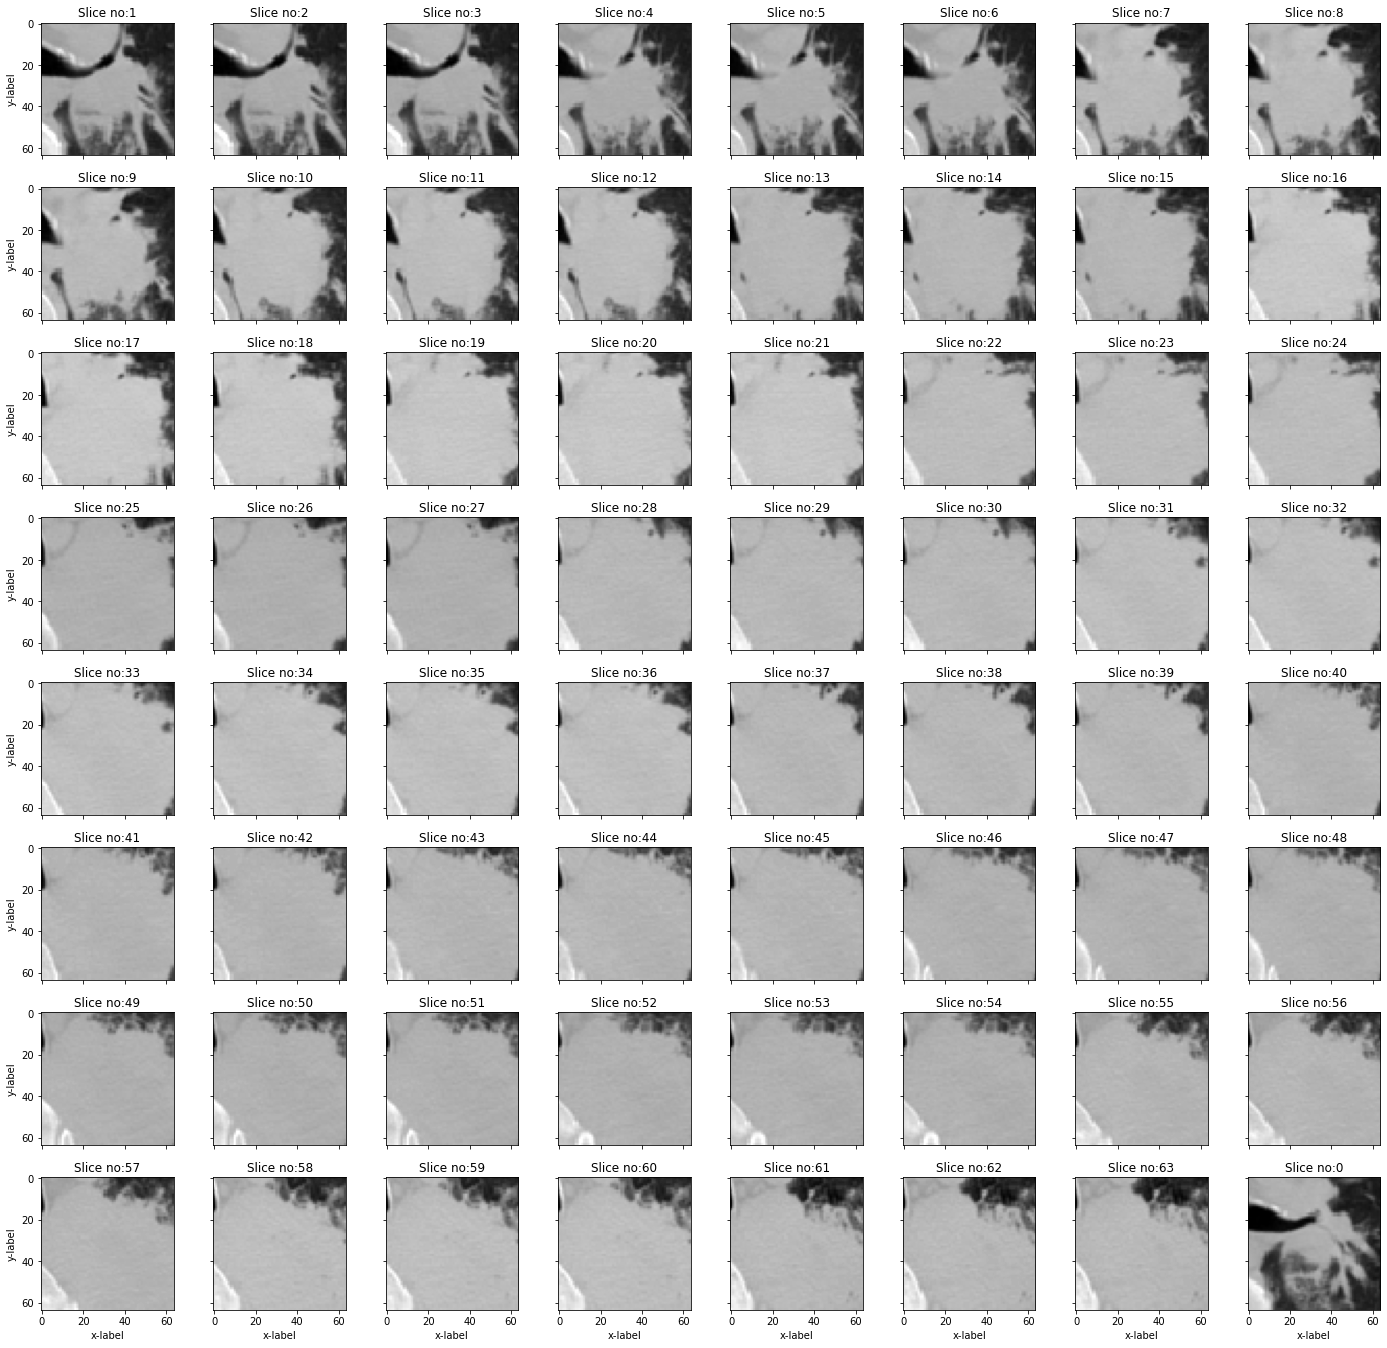

In [287]:
fig, axs = plt.subplots(8, 8,figsize=(24,24),sharex='col', sharey='row',gridspec_kw={'hspace': 0.1, 'wspace': 0.3})

# First Row

axs[0, 0].imshow(my_img[:,:,1],cmap='gray')
axs[0, 0].set_title('Slice no:1')
axs[0, 1].imshow(my_img[:,:,2],cmap='gray')
axs[0, 1].set_title('Slice no:2')
axs[0, 2].imshow(my_img[:,:,3],cmap='gray')
axs[0, 2].set_title('Slice no:3')
axs[0, 3].imshow(my_img[:,:,4],cmap='gray')
axs[0, 3].set_title('Slice no:4')
axs[0, 4].imshow(my_img[:,:,5],cmap='gray')
axs[0, 4].set_title('Slice no:5')
axs[0, 5].imshow(my_img[:,:,6],cmap='gray')
axs[0, 5].set_title('Slice no:6')
axs[0, 6].imshow(my_img[:,:,7],cmap='gray')
axs[0, 6].set_title('Slice no:7')
axs[0, 7].imshow(my_img[:,:,8],cmap='gray')
axs[0, 7].set_title('Slice no:8')

# Second Row

axs[1, 0].imshow(my_img[:,:,9],cmap='gray')
axs[1, 0].set_title('Slice no:9')
axs[1, 1].imshow(my_img[:,:,10],cmap='gray')
axs[1, 1].set_title('Slice no:10')
axs[1, 2].imshow(my_img[:,:,11],cmap='gray')
axs[1, 2].set_title('Slice no:11')
axs[1, 3].imshow(my_img[:,:,12],cmap='gray')
axs[1, 3].set_title('Slice no:12')
axs[1, 4].imshow(my_img[:,:,13],cmap='gray')
axs[1, 4].set_title('Slice no:13')
axs[1, 5].imshow(my_img[:,:,14],cmap='gray')
axs[1, 5].set_title('Slice no:14')
axs[1, 6].imshow(my_img[:,:,15],cmap='gray')
axs[1, 6].set_title('Slice no:15')
axs[1, 7].imshow(my_img[:,:,16],cmap='gray')
axs[1, 7].set_title('Slice no:16')

# Third Row

axs[2, 0].imshow(my_img[:,:,17],cmap='gray')
axs[2, 0].set_title('Slice no:17')
axs[2, 1].imshow(my_img[:,:,18],cmap='gray')
axs[2, 1].set_title('Slice no:18')
axs[2, 2].imshow(my_img[:,:,19],cmap='gray')
axs[2, 2].set_title('Slice no:19')
axs[2, 3].imshow(my_img[:,:,20],cmap='gray')
axs[2, 3].set_title('Slice no:20')
axs[2, 4].imshow(my_img[:,:,21],cmap='gray')
axs[2, 4].set_title('Slice no:21')
axs[2, 5].imshow(my_img[:,:,22],cmap='gray')
axs[2, 5].set_title('Slice no:22')
axs[2, 6].imshow(my_img[:,:,23],cmap='gray')
axs[2, 6].set_title('Slice no:23')
axs[2, 7].imshow(my_img[:,:,24],cmap='gray')
axs[2, 7].set_title('Slice no:24')

# Fourth Row

axs[3, 0].imshow(my_img[:,:,25],cmap='gray')
axs[3, 0].set_title('Slice no:25')
axs[3, 1].imshow(my_img[:,:,26],cmap='gray')
axs[3, 1].set_title('Slice no:26')
axs[3, 2].imshow(my_img[:,:,27],cmap='gray')
axs[3, 2].set_title('Slice no:27')
axs[3, 3].imshow(my_img[:,:,28],cmap='gray')
axs[3, 3].set_title('Slice no:28')
axs[3, 4].imshow(my_img[:,:,29],cmap='gray')
axs[3, 4].set_title('Slice no:29')
axs[3, 5].imshow(my_img[:,:,30],cmap='gray')
axs[3, 5].set_title('Slice no:30')
axs[3, 6].imshow(my_img[:,:,31],cmap='gray')
axs[3, 6].set_title('Slice no:31')
axs[3, 7].imshow(my_img[:,:,32],cmap='gray')
axs[3, 7].set_title('Slice no:32')

# Fifth Row

axs[4, 0].imshow(my_img[:,:,33],cmap='gray')
axs[4, 0].set_title('Slice no:33')
axs[4, 1].imshow(my_img[:,:,34],cmap='gray')
axs[4, 1].set_title('Slice no:34')
axs[4, 2].imshow(my_img[:,:,35],cmap='gray')
axs[4, 2].set_title('Slice no:35')
axs[4, 3].imshow(my_img[:,:,36],cmap='gray')
axs[4, 3].set_title('Slice no:36')
axs[4, 4].imshow(my_img[:,:,37],cmap='gray')
axs[4, 4].set_title('Slice no:37')
axs[4, 5].imshow(my_img[:,:,38],cmap='gray')
axs[4, 5].set_title('Slice no:38')
axs[4, 6].imshow(my_img[:,:,39],cmap='gray')
axs[4, 6].set_title('Slice no:39')
axs[4, 7].imshow(my_img[:,:,40],cmap='gray')
axs[4, 7].set_title('Slice no:40')

# Sixth Row

axs[5, 0].imshow(my_img[:,:,41],cmap='gray')
axs[5, 0].set_title('Slice no:41')
axs[5, 1].imshow(my_img[:,:,42],cmap='gray')
axs[5, 1].set_title('Slice no:42')
axs[5, 2].imshow(my_img[:,:,43],cmap='gray')
axs[5, 2].set_title('Slice no:43')
axs[5, 3].imshow(my_img[:,:,44],cmap='gray')
axs[5, 3].set_title('Slice no:44')
axs[5, 4].imshow(my_img[:,:,45],cmap='gray')
axs[5, 4].set_title('Slice no:45')
axs[5, 5].imshow(my_img[:,:,46],cmap='gray')
axs[5, 5].set_title('Slice no:46')
axs[5, 6].imshow(my_img[:,:,47],cmap='gray')
axs[5, 6].set_title('Slice no:47')
axs[5, 7].imshow(my_img[:,:,48],cmap='gray')
axs[5, 7].set_title('Slice no:48')

# Seventh Row

axs[6, 0].imshow(my_img[:,:,49],cmap='gray')
axs[6, 0].set_title('Slice no:49')
axs[6, 1].imshow(my_img[:,:,50],cmap='gray')
axs[6, 1].set_title('Slice no:50')
axs[6, 2].imshow(my_img[:,:,51],cmap='gray')
axs[6, 2].set_title('Slice no:51')
axs[6, 3].imshow(my_img[:,:,52],cmap='gray')
axs[6, 3].set_title('Slice no:52')
axs[6, 4].imshow(my_img[:,:,53],cmap='gray')
axs[6, 4].set_title('Slice no:53')
axs[6, 5].imshow(my_img[:,:,54],cmap='gray')
axs[6, 5].set_title('Slice no:54')
axs[6, 6].imshow(my_img[:,:,55],cmap='gray')
axs[6, 6].set_title('Slice no:55')
axs[6, 7].imshow(my_img[:,:,56],cmap='gray')
axs[6, 7].set_title('Slice no:56')

# Eighth Row

axs[7, 0].imshow(my_img[:,:,57],cmap='gray')
axs[7, 0].set_title('Slice no:57')
axs[7, 1].imshow(my_img[:,:,58],cmap='gray')
axs[7, 1].set_title('Slice no:58')
axs[7, 2].imshow(my_img[:,:,59],cmap='gray')
axs[7, 2].set_title('Slice no:59')
axs[7, 3].imshow(my_img[:,:,60],cmap='gray')
axs[7, 3].set_title('Slice no:60')
axs[7, 4].imshow(my_img[:,:,61],cmap='gray')
axs[7, 4].set_title('Slice no:61')
axs[7, 5].imshow(my_img[:,:,62],cmap='gray')
axs[7, 5].set_title('Slice no:62')
axs[7, 6].imshow(my_img[:,:,63],cmap='gray')
axs[7, 6].set_title('Slice no:63')
axs[7, 7].imshow(my_img[:,:,0],cmap='gray')
axs[7, 7].set_title('Slice no:0')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()